# Определение стоимости автомобилей

Введение:Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Цель проекта: Построить модель, которая умеет определять рыночную стоимость автомобиля. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

План работы:
1. Подготова данных.
2. Обучение моделей.
3. Анализ моделей.
4. Общий вывод.

Примечания:
* Для оценки качества моделей применяйте метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.
* Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
* Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
* Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
* Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.


Описание данных:
Данные находятся в файле /datasets/autos.csv. Скачать датасет. 

Признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
Целевой признак
* Price — цена (евро)

In [1]:
#!pip install phik -q

In [2]:
#!pip install lightgbm -q

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from matplotlib import pyplot as plt
import phik
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error 
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
from time import time

In [4]:
RANDOM_STATE = 42

## Подготовка данных

### Загрузка данных

In [5]:
# Загружаю данные
autos = pd.read_csv('autos.csv')

In [6]:
# Изучим данные
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
max(autos['DateCrawled'])

'2016-04-07 14:36:58'

In [8]:
autos.shape

(354369, 16)

In [9]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Вижу пропуски в данных. Также считаю признаки PostalCode, NumberOfPictures, RegistrationMonth, LastSeen, DateCreated, DateCrawled неинформативными. Буду удалять.

### Предобработка данных

In [10]:
# Поищем явные дубликаты
autos.duplicated().sum()

4

In [11]:
# удаляю явные дубликаты
autos = autos.drop_duplicates()

In [12]:
# проверяю наличие неячвных дубликатов
autos['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [13]:
autos['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [14]:
autos['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [15]:
autos['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [16]:
autos['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [17]:
autos['FuelType'] = autos['FuelType'].replace('petrol', 'gasoline')
autos['Model'] = autos['Model'].replace('rangerover', 'range_rover')

In [18]:
# удаляю неинформативные признаки
autos = autos.drop(['PostalCode', 'NumberOfPictures', 'RegistrationMonth', 'LastSeen', 'DateCreated', 'DateCrawled'], axis=1)
autos.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,gasoline,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Признаки VehicleType, Gearbox, Model, FuelType, Repaired содержат пропуски. Заменю на категорию 'other'. А пропуски в Repaired на 'no'.

In [19]:
autos['VehicleType'] = autos['VehicleType'].fillna('other')

In [20]:
autos['Gearbox'] = autos['Gearbox'].fillna('other')

In [21]:
autos['Model'] = autos['Model'].fillna('other')

In [22]:
autos['FuelType'] = autos['FuelType'].fillna('other')

In [23]:
autos['Repaired'] = autos['Repaired'].fillna('no')

In [24]:
# нулевые значения в признаке Power меняю на среднее значение
# utos['Power'] = autos['Power'].replace (0, np.nan, regex= True)
# power_avg = autos['Power'].mean()
# autos['Power'] = autos['Power'].fillna(power_avg)

### Анализ данных

In [25]:
cat_cols = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
num_cols = ['RegistrationYear', 'Power', 'Kilometer']

In [26]:
# Проведем статистический анализ всех признаков.
# Количественные признаки
# функция для построения ящиков с усами и гистограммы (для числовых признаков)
def boxplot_(df, column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.boxplot(data=df, x=column, ax=axes[0])
    axes[0].set_title(f'Ящик с усами для столбца "{column}"')
    axes[0].set_ylabel('Количество')

    sns.histplot(data=df, x=column, kde=True, ax=axes[1])
    axes[1].set_title(f'Гистограмма для столбца "{column}"')
    axes[1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

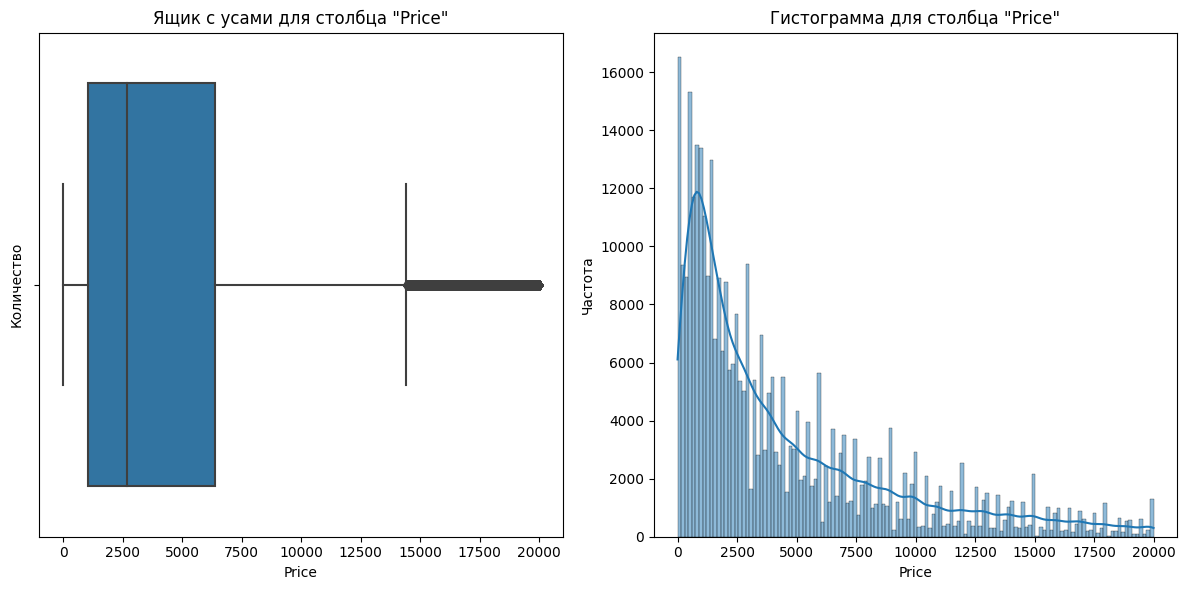

In [27]:
boxplot_(autos, 'Price')

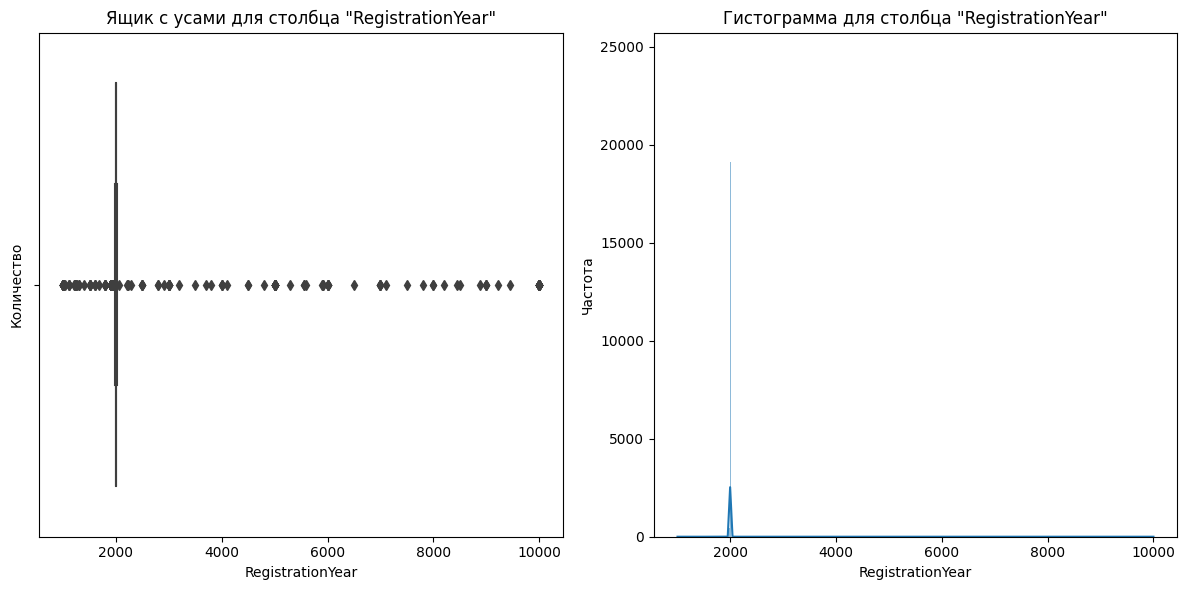

In [28]:
boxplot_(autos, 'RegistrationYear')

In [29]:
autos.query('Price == 0')['Price'].count()

10772

В результате анализа целевого признака Price считаю данные, где стоимость автомобиля дешевле 600 евро аномалиями. Удаляю.

In [30]:
autos = autos[(autos['Price'] > 500)]

In [31]:
autos.query('RegistrationYear > 2016')['Price'].count()

12843

In [32]:
autos.query('RegistrationYear < 1995')['Price'].count()

20191

В результате анализа признака RegistrationYear считаю данные вне промежутка 1995 и 2016 года аномалиями и устаревшими. Удаляю.

In [33]:
autos = autos[(autos['RegistrationYear'] <= 2016)]
autos = autos[(autos['RegistrationYear'] >= 1995)]
autos.shape

(279607, 10)

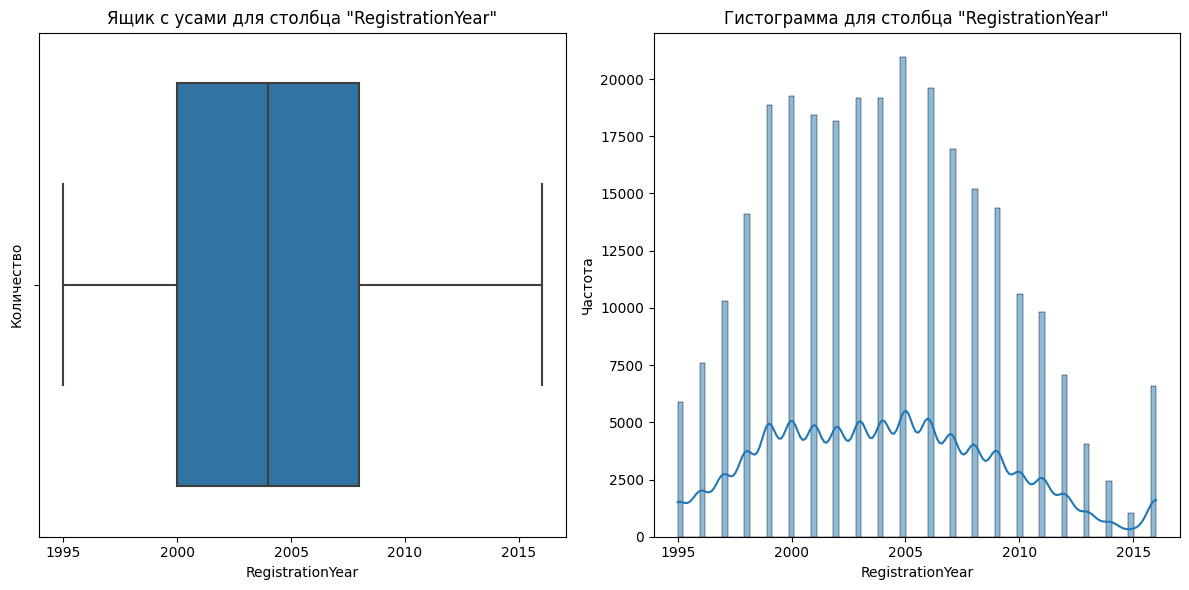

In [34]:
boxplot_(autos, 'RegistrationYear')

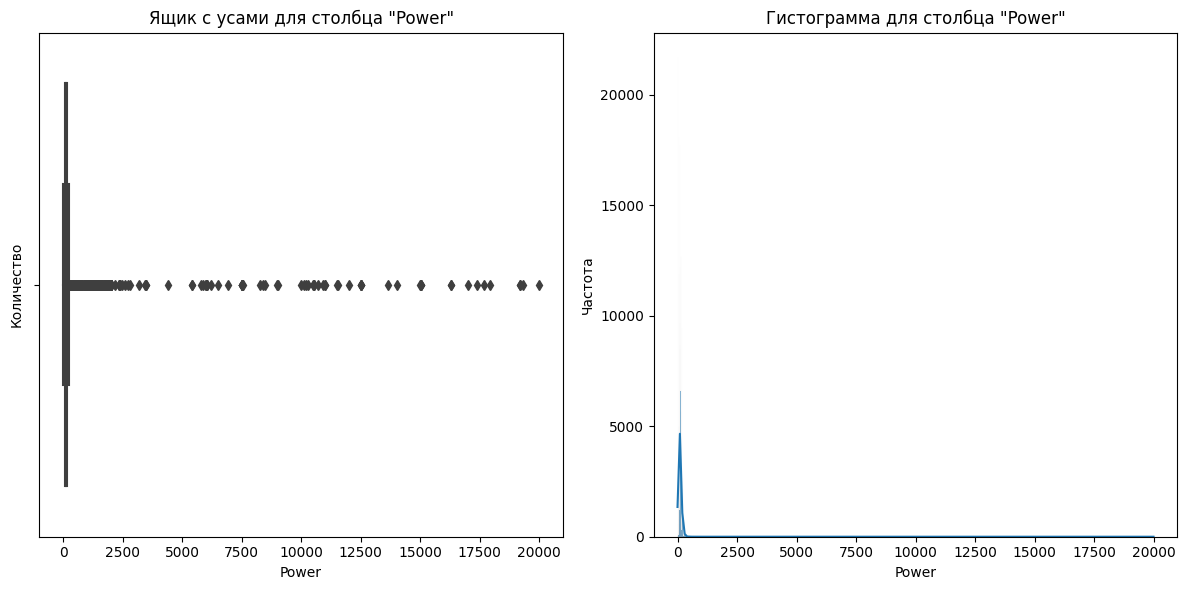

In [35]:
boxplot_(autos, 'Power')

В результате анализа признака Power считаю данные со значениями больше 400 л.с. и меньше 20 л.с. аномалиями. Удаляю.

In [36]:
autos.query('Power < 20')['Power'].count()

21950

In [37]:
autos = autos[(autos['Power'] >= 20)]

In [38]:
autos.query('Power > 400')['Power'].count()

558

In [39]:
autos = autos[(autos['Power'] < 400)]
autos.shape

(257057, 10)

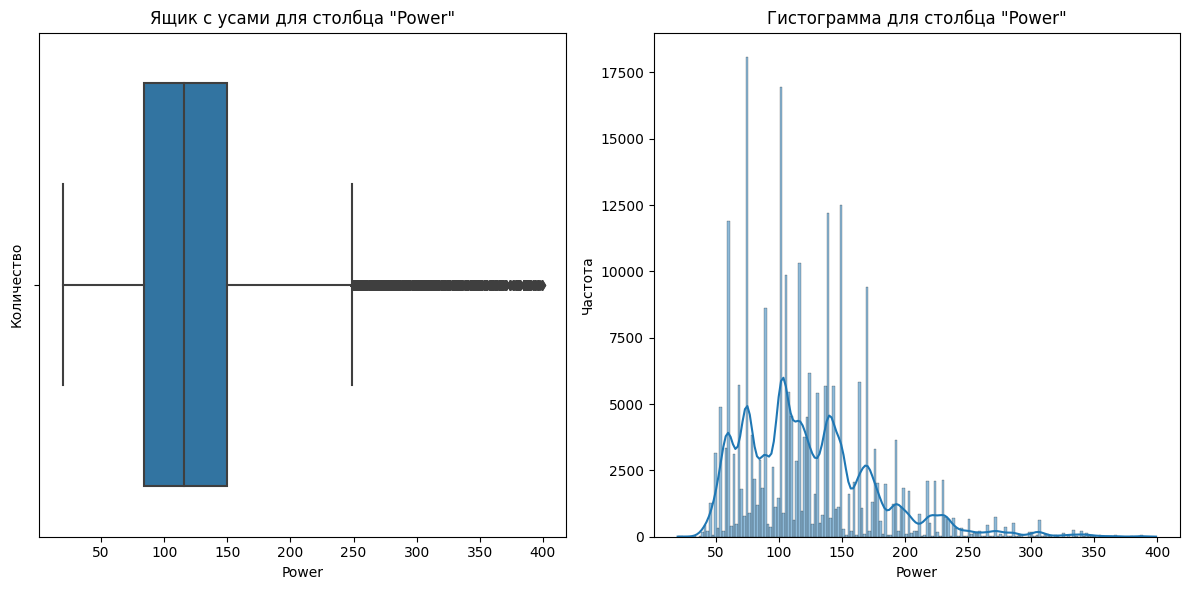

In [40]:
boxplot_(autos, 'Power')

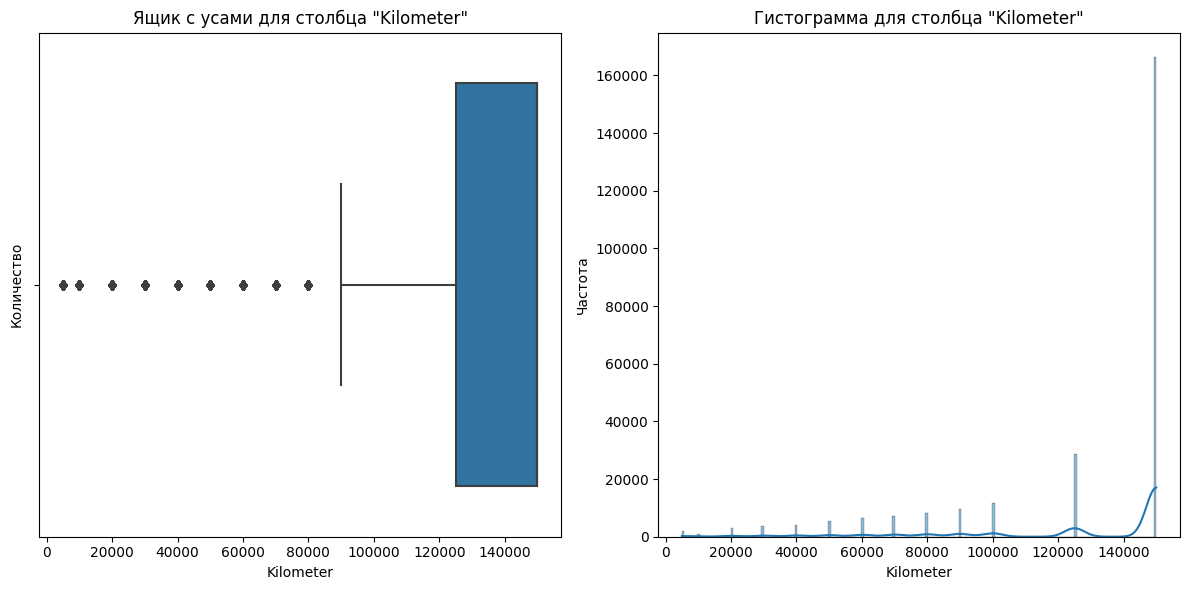

In [41]:
boxplot_(autos, 'Kilometer')

In [42]:
# Категориальные признаки
cat_cols = ['VehicleType','Gearbox', 'FuelType', 'Repaired']

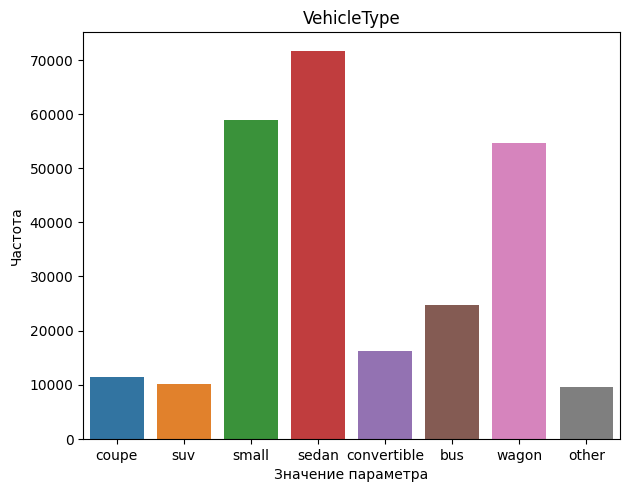

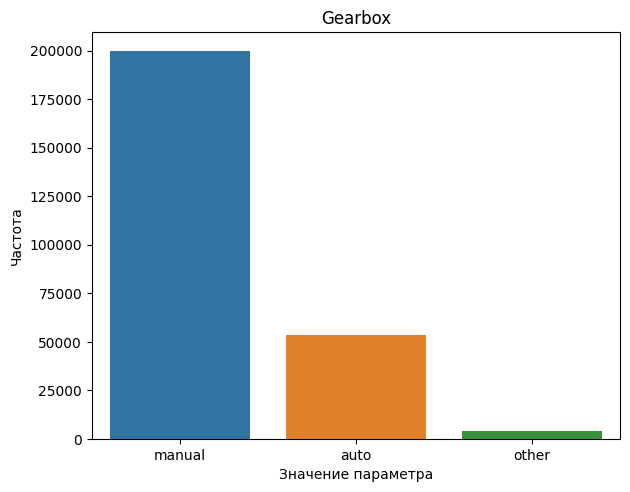

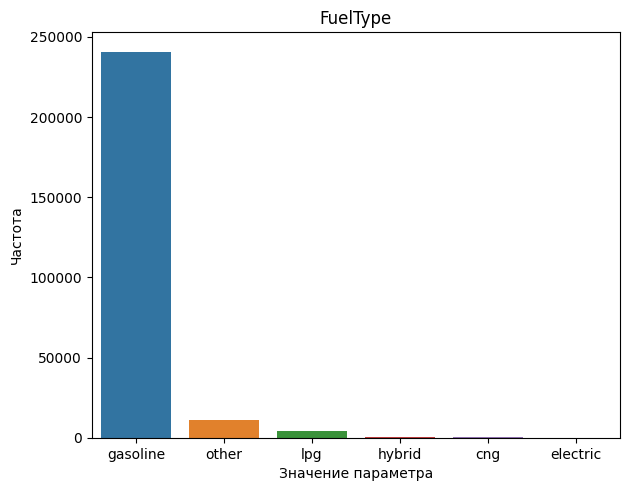

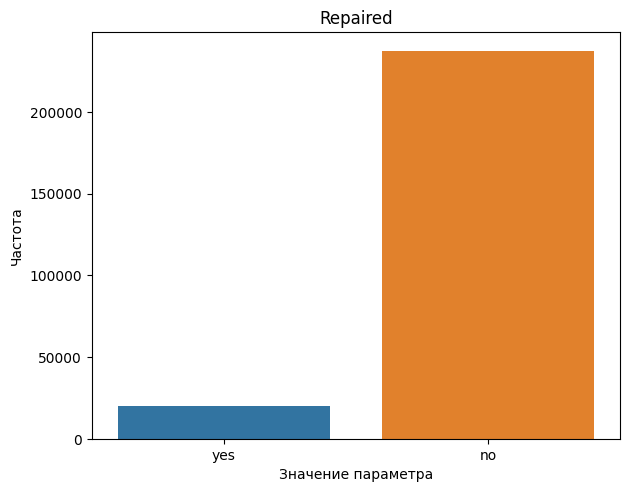

In [43]:
for col in cat_cols:  
    ax=sns.countplot(x=col, data = autos)
    plt.tight_layout()
    plt.title(col)
    plt.xlabel('Значение параметра')
    plt.ylabel('Частота')
    plt.show()

Категориальные признаки Model и Brand имеют слишком много значений для отображения. Считаю что все значения важны. 

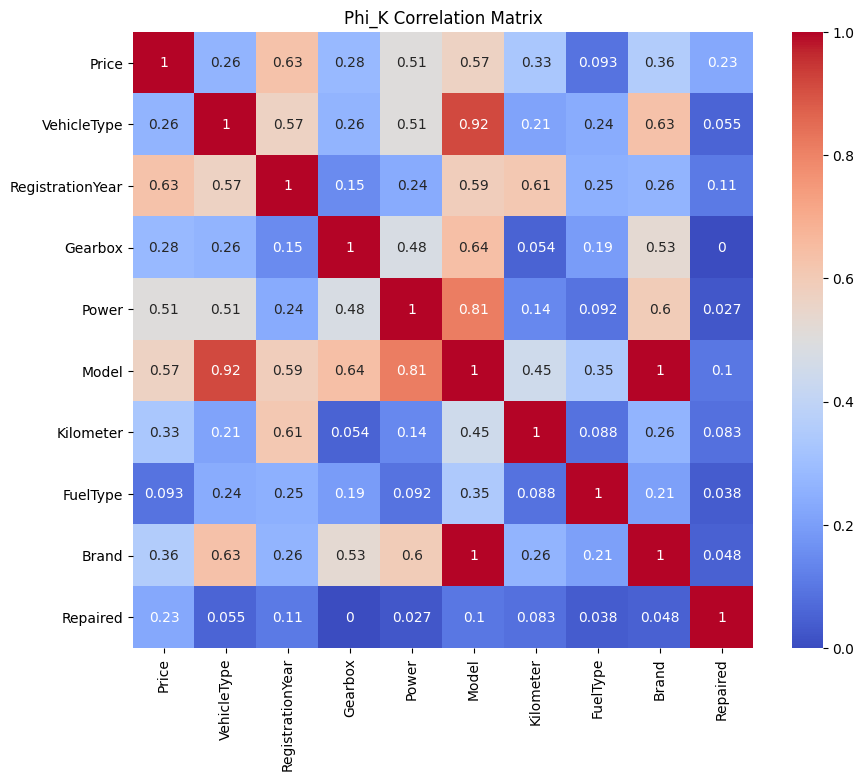

In [44]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = autos.phik_matrix(interval_cols=['Price', 'Power'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

Признак Model очень сильно коррелирует с двумя признаками Brand и VehicleType. Удаляю признак.

In [45]:
autos = autos.drop(['Model'], axis=1)

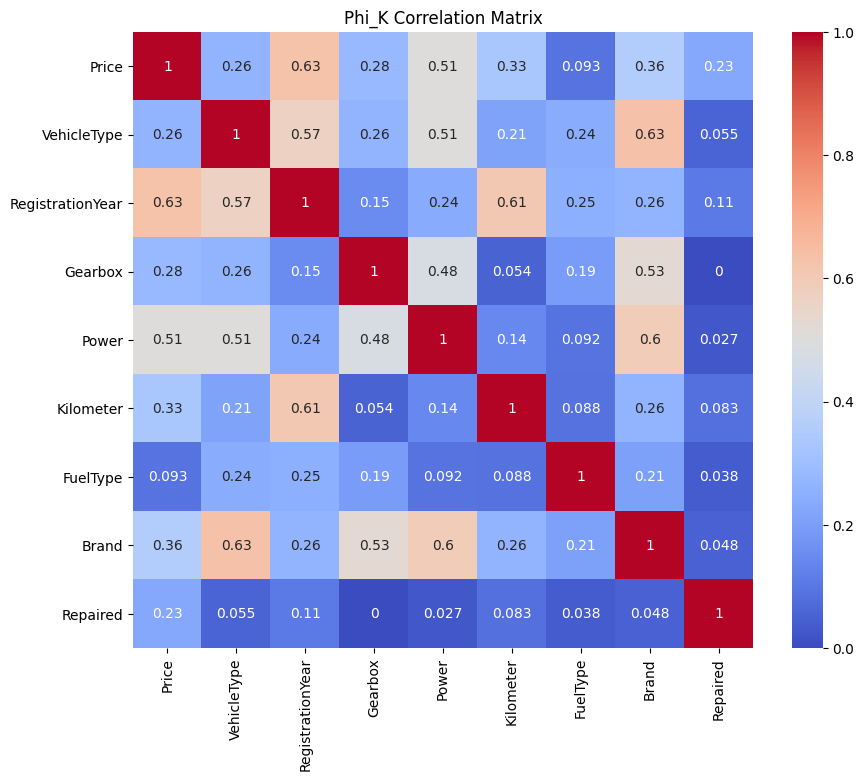

In [46]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = autos.phik_matrix(interval_cols=['Price', 'Power'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

### Подготовка выборки для обучения моделей.

In [47]:
# Подготовим выборки для обучения моделей.
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,150000,gasoline,bmw,yes


In [48]:
autos.duplicated().sum()

47368

In [49]:
# удаляю явные дубликаты
autos = autos.drop_duplicates()

In [50]:
autos['Kilometer'].unique()

array([125000, 150000,  90000,  30000,  70000, 100000,  60000,  20000,
        80000,   5000,  50000,  40000,  10000], dtype=int64)

In [51]:
autos['RegistrationYear'].unique()

array([2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2007, 2009, 2002,
       2003, 2016, 2006, 1999, 2012, 2010, 2000, 1997, 2013, 1996, 2015],
      dtype=int64)

In [52]:
# Создаем списки категориальных и количественных признаков
cat_cols = ['VehicleType','Gearbox', 'FuelType', 'Brand', 'Repaired', 'RegistrationYear', 'Kilometer']
num_cols = ['Power']

In [53]:
# привел категориальные признаки к типу category
for col in cat_cols:
    autos[col] = autos[col].astype('category')
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209689 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             209689 non-null  int64   
 1   VehicleType       209689 non-null  category
 2   RegistrationYear  209689 non-null  category
 3   Gearbox           209689 non-null  category
 4   Power             209689 non-null  int64   
 5   Kilometer         209689 non-null  category
 6   FuelType          209689 non-null  category
 7   Brand             209689 non-null  category
 8   Repaired          209689 non-null  category
dtypes: category(7), int64(2)
memory usage: 6.2 MB


In [54]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(autos.drop('Price', axis=1),
                                                                autos['Price'], test_size=0.4, 
                                                                random_state=RANDOM_STATE)

In [55]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=RANDOM_STATE) 

In [56]:
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape,  y_test.shape)

(125813, 8) (41938, 8) (41938, 8) (125813,) (41938,) (41938,)


Загрузил данные. Провел предобработку данных. 
* удалил явные дубликаты. 
* удалил неинформативные признаки 'PostalCode', 'NumberOfPictures', 'RegistrationMonth', 'LastSeen', 'DateCreated', 'DateCrawled'.
* устранил пропуски в данных: Признаки VehicleType, Gearbox, Model, FuelType, Repaired содержат пропуски. Заменил на категорию 'other'. А пропуски в Repaired на 'no'.
* нулевые и околонулевые значения в признаке Power - наблюденя удалил
Провел анализ данных. В результате анализа удалил аномальные значения и ограничил выборку автомобилей годами выуска 1995 и 2016.
И удалил аномальные значения мощности двигателя, ограничив с 30 л.с по 400 л.с
В результате корреляционного анализа убрал признак Model

Признаки Kilometer и RegistrationYear будем применять как  категория. Они имеют распределение категориального признака, так как задано небольшое количество уникальных значений.

Разбил данные на выборки(сплентирование)

## Обучение моделей

### Модель LightGBM для градиентного бустинга

In [72]:
#LightGBM для градиентного бустинга
train_dataset = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.values.tolist())
valid_dataset = lgb.Dataset(X_valid, y_valid, feature_name=X_train.columns.values.tolist())

In [73]:
#количество деревьев бустинга
booster = lgb.train({"objective": "regression"},
                    train_set=train_dataset, 
                    valid_sets=(valid_dataset),
                    num_boost_round=5000, 
                    categorical_feature=cat_cols)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 125813, number of used features: 8
[LightGBM] [Info] Start training from score 5499.775516


In [74]:
train_preds = booster.predict(X_valid)

In [81]:
np.sqrt(mean_squared_error(y_valid, train_preds))

1595.6786481989004

In [83]:
num_trees = booster.num_trees()

In [84]:
booster = lgb.LGBMModel(objective="regression", n_estimators=num_trees, random_state=RANDOM_STATE)

In [85]:
start = time()
booster.fit(X_train, y_train, categorical_feature=cat_cols)
end = time()
lgbm_model_time = (end-start)/60

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 125813, number of used features: 8
[LightGBM] [Info] Start training from score 5499.775516


In [87]:
start = time()
train_preds = booster.predict(X_valid)
lgbm_rmse = np.sqrt(mean_squared_error(y_valid, train_preds))
end = time()
lgbm_preds_time = (end-start)/60
lgbm_rmse

1595.6786481989004

### Модель линейной регрессии

In [ ]:
#pip install --upgrade scikit-learn

In [88]:
# Масштабируем количественные признаки для тренировочной и тестовой выборок с помощью стандартизации.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_valid[num_cols])

In [89]:
# Закодируем категориальные признаки в тренировочной и тестовой выборках.
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [90]:
X_train_ohe = encoder.fit_transform(X_train[cat_cols])
X_test_ohe = encoder.transform(X_valid[cat_cols])

In [91]:
X_train_ohe = encoder.fit_transform(X_train[cat_cols])
X_test_ohe = encoder.transform(X_valid[cat_cols])
encoder_col_names = encoder.get_feature_names_out()

In [92]:
# Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols)
X_train_lr = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_valid_lr = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [93]:
start = time()
#Обучение модели линейной регрессии
model_lr  = LinearRegression()
model_lr.fit(X_train_lr, y_train)
end = time()
lr_model_time = (end-start)/60

In [95]:
start = time()
test_preds = model_lr.predict(X_valid_lr)
lr_rmse = np.sqrt(mean_squared_error(y_valid, test_preds))
end = time()
lr_preds_time = (end-start)/60
lr_rmse

2179.773026344415

### Дерево решений

In [96]:
# Масштабируем количественные признаки для тренировочной и тестовой выборок с помощью стандартизации.
scaler = StandardScaler()
X_train_tree = X_train
X_valid_tree = X_valid
X_test_tree = X_test
X_train_tree[num_cols] = scaler.fit_transform(X_train_tree[num_cols])
X_valid_tree[num_cols] = scaler.transform(X_valid_tree[num_cols])
X_test_tree[num_cols] = scaler.transform(X_test_tree[num_cols])

In [97]:
# кодирую признаки
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

In [98]:
X_train_tree[cat_cols] = ordinal_encoder.fit_transform(X_train_tree[cat_cols])
X_valid_tree[cat_cols] = ordinal_encoder.transform(X_valid_tree[cat_cols])
X_test_tree[cat_cols] = ordinal_encoder.transform(X_test_tree[cat_cols])

In [99]:
# заменим неизвестные категории
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
simple_imputer.fit(X_train_tree[cat_cols])
X_test_tree[cat_cols] = simple_imputer.transform(X_test_tree[cat_cols])

In [101]:
results = []
for min_samples_leaf in range(2, 21):
    for max_depth in range(2, 21):
        model = model = DecisionTreeRegressor(
                random_state=RANDOM_STATE,
                min_samples_leaf=min_samples_leaf, 
                max_depth=max_depth
            )
        model.fit(X_train, y_train)
        valid_preds = model.predict(X_valid_tree)
        tree_rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
        results.append((tree_rmse, {
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth
            }))

In [102]:
results = pd.DataFrame(results, columns=['tree_rmse', 'param'])       

In [103]:
results[results['tree_rmse'] == results['tree_rmse'].min()]

,tree_rmse,param
132,1782.22998,"{'min_samples_leaf': 8, 'max_depth': 20}"


In [104]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE,
                              max_depth=20,
                              min_samples_leaf=8)

In [105]:
start = time()
model.fit(X_train, y_train)
end = time()
tree_model_time = (end-start)/60

In [107]:
start = time()
test_preds = model.predict(X_valid_tree)
tree_rmse = np.sqrt(mean_squared_error(y_valid, test_preds))
end = time()
tree_preds_time = (end-start)/60
tree_rmse

1782.2299798894915

В результате было построено 3 модели для сравнения.
* Модель LightGBM для градиентного бустинга количество деревьев бустинга
* Модель линейной регрессии
* Дерево решений
Для каждой модели была найдена метрика RMSE, время обучения модели и время предсказания модели.

## Анализ моделей

In [108]:
#Проанализируем полученные результаты.
df = pd.DataFrame([['lgbm', lgbm_rmse, lgbm_model_time, lgbm_preds_time],
                  ['lr', lr_rmse, lr_model_time, lr_preds_time],
                  ['tree', tree_rmse, tree_model_time, tree_preds_time]], 
columns=['Модель','метрика RMSE', 'время обучения', 'время предсказания'])
df

,Модель,метрика RMSE,время обучения,время предсказания
0,lgbm,1595.678648,0.105950,0.043451
1,lr,2179.773026,0.014428,0.000150
2,tree,1782.229980,0.003939,0.000216


In [110]:
test_preds = model.predict(X_test_tree)
rmse_best_model = np.sqrt(mean_squared_error(y_test, test_preds))
rmse_best_model

1784.4342898178984

Опираясь на критерии заказчика, я выбираю модель Дерево решений c финальной метрикой RMSE=1785. Модель lgbm долго обучается, хоть и более качественная.

## Общий вывод

Целью проекта является построить модель, которая умеет определять рыночную стоимость автомобиля с критериями заказчика: 
- качество предсказания;
- скорость предсказания;
- время обучения.

Загрузил данные. Провел предобработку данных. 
* удалил явных дубликата. 
* удалил неинформативные признаки 'PostalCode', 'NumberOfPictures', 'RegistrationMonth', 'LastSeen', 'DateCreated', 'DateCrawled'.
* устранил пропуски в данных: Признаки VehicleType, Gearbox, Model, FuelType, Repaired содержат пропуски. Заменил на категорию 'other'. А пропуски в Repaired на 'no'.
* нулевые и околонулевые значения в признаке Power - наблюденя удалил

Провел анализ данных. В результате анализа удалил аномальные значения и ограничил выборку автомобилей годами выуска 1995 и 2016.
И удалил аномальные значения мощности двигателя, ограничив с 30 л.с по 400 л.с
В результате корреляционного анализа убрал признак Model

Признаки Kilometer и RegistrationYear будем применять как  категория. Они имеют распределение категориального признака, так как задано небольшое количество уникальных значений.

Разбил данные на выборки(сплентирование)

В результате было построено 3 модели для сравнения.
* Модель LightGBM для градиентного бустинга количество деревьев бустинга
* Модель линейной регрессии
* Дерево решений
Для каждой модели была найдена метрика RMSE, время обучения модели и время предсказания модели.

Опираясь на критерии заказчика, я выбираю модель Дерево решений c финальной метрикой RMSE=1785. Модель lgbm долго обучается, хоть и более качественная.